#### Week 3: Building Advanced RAG Applications.  Authored by Chris Sanchez.

# Week 3 - Notebook 8 --> Text2SQL

# Overview
---
For the full context on the topic of this notebook, review the **Text2SQL** section of the [Week 3 Course Content](https://uplimit.com/course/rag-applications/session/session_clzlsa20a01di197e4tij7vgm/module/text2sql). 
 
This notebook will walk you through the process of creating a Text2SQL pipeline which will aid in expanding the number of total answerable questions by your RAG system.  This notebook will implement the following steps:
- Create a `sqlite3` database and populate it with corpus metadata that we already have available in the `data/metadata` directory.
- Import and train a Semantic Router for query routing.
- Define system and user message prompts for creating a Text2SQL LLM call
- Create a basic dataflow pipeline for the execution of a SQL query route

![Text2SQL pipeline]( 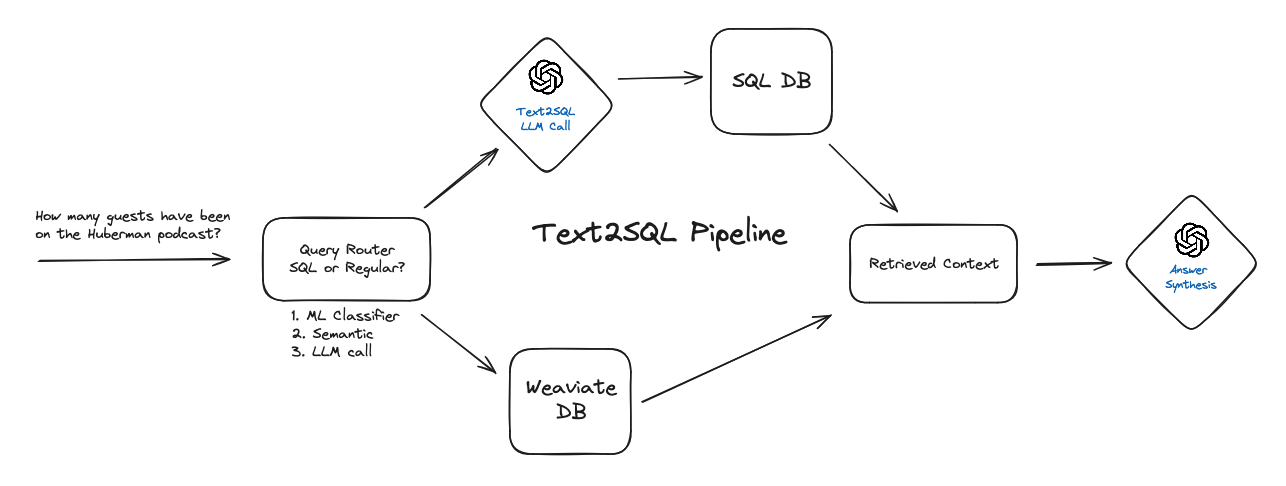)

In [64]:
import os
import sys
sys.path.append('../')

from random import shuffle
from src.preprocessor.preprocessing import FileIO
from src.llm.llm_interface import LLM
import sqlite3

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv(), override=True)

endpoint = os.environ['WEAVIATE_ENDPOINT']
api_key = os.environ['WEAVIATE_API_KEY']

In [ ]:
#required for this notebook 
!pip install -q semantic-router

### Import Metadata
This metadata is not additional data collected from an external source, rather it is simply metadata extracted from the original `huberman_labs.json` source. 

In [ ]:
data_dir = '../data/metadata/'
data: list[tuple] = []
names = ['guests', 'titles', 'short_summaries', 'view_counts']

#each metadata category will be appended as a tuple
for name in names:
    data.append(tuple(FileIO.load_json(f'{data_dir}{name}.json')))

### Create Database and Ingest Data
---

In [ ]:
file = 'sqlite3.db'

In [ ]:
#this command will create the sqlite3.db file on disk if it doesn't already exist
conn= sqlite3.connect(file)
cursor = conn.cursor()

#### Create basic table
We'll create a single `huberman` table with 5 columns.

In [ ]:
table_schema = """
CREATE TABLE IF NOT EXISTS huberman (
    id INTEGER PRIMARY KEY,
    guests TEXT NOT NULL,
    titles TEXT NOT NULL,
    summaries TEXT NOT NULL,
    view_counts INTEGER NOT NULL
);
"""

In [ ]:
#upload table schema
_ = cursor.execute(table_schema)

### Results Check

In [ ]:
# run a command to check that the table exists on the DB
_ = cursor.execute("SELECT count(*) FROM sqlite_master WHERE type='table' AND name='huberman';")
result = cursor.fetchall()

#should be a list with a 1 returned (0 means the table does not exist)
print(result)

#### Insert Data into DB

In [ ]:
#automate our connection and cursor setup

def get_cursor(file: str='./sqlite3.db'):
    '''
    Creates a sqlite connection and cursor for query execution, 
    from a sqlite filepath.
    '''
    conn = sqlite3.connect(file)
    cursor = conn.cursor()
    return cursor, conn

In [ ]:
def insert_rows(guests: tuple[str], 
                titles: tuple[str],
                summaries: tuple[str],
                counts: tuple[str]
               ): 
    '''
    Inserts multiple rows into sqlite database.
    '''
    cursor, conn = get_cursor()
    for i, (guest, title, summary, count) in enumerate(zip(guests, titles, summaries, counts)):
        insert_query =  f"""
                        INSERT INTO huberman (id, guests, titles, summaries, view_counts)
                        VALUES (?,?,?,?,?);
                        """
        cursor.execute(insert_query, (i, guest, title, summary, count))
    conn.commit()
    cursor.close()
    conn.close()

#### Extract data and insert

In [ ]:
# extract tuples of data categories
guests, titles, summaries, view_counts = [*data]

In [ ]:
#data insertion command
insert_rows(guests, titles, summaries, view_counts)

#### Check that data was inserted

In [ ]:
def get_response(command: str):
    '''
    Creates cursor and executes SQL command.
    Closes db connection and returns answer. 
    '''
    cursor, conn = get_cursor()
    cursor.execute(command)
    answer = cursor.fetchall()
    cursor.close()
    conn.close()
    return answer

In [ ]:
command = "SELECT * FROM huberman"
result = get_response(command)
id_num = 4
id, guest, title, summary, view_count = [*result[id_num]]
print(f'ID: {id}')
print(f'Guest: {guest}')
print(f'Title: {title}')
print(f'Summary: {summary}')
print(f'View Count: {view_count}')

<details>
    <summary>
        If the "id_num" variable is set to 4, you should see the below result. 
    </summary>

```
ID: 4
Guest: Dr. E.J. Chichilnisky
Title: Dr. E.J. Chichilnisky: How the Brain Works, Curing Blindness & How to Navigate a Career Path
Summary: In the Huberman Lab podcast episode featuring Dr. E.J. Chichilnisky, the discussion centers on understanding visual perception and applying that knowledge to the development of neural prostheses to cure blindness. Dr. Chichilnisky, a professor at Stanford University, delves into the encoding of the visual world by neurons in the brain and the potential to engineer devices that can not only restore sight to the blind but also enhance memory and cognition. The conversation also explores the importance of choosing one's professional path, with Dr. Chichilnisky sharing his unconventional journey through science and how it shaped his focus on neuroscience and medicine. The episode emphasizes the significance of translating scientific understanding into practical applications that can improve lives.
View Count: 111855
```
</details>

##### SQL Database: We now have a SQL database populated with our metadata which represents a structured way of retrieving information.

## Semantic Router
---

[Semantic-Router](https://github.com/aurelio-labs/semantic-router) is a library to build decision-making layers for your LLM calls. A Semantic Router uses vector embeddings to make tool-use decisions rather than LLM generations, routing our requests using semantic meaning.  Building a Semantic Router requires the following three steps:
- Choose an embedding model
- Define routes (based on sample queries)
- Train the router

#### Choose embedding model
Works with most SentenceTransformer-based models

In [ ]:
from semantic_router.encoders import HuggingFaceEncoder

# get embedding model
model_path = 'BAAI/bge-base-en'
encoder = HuggingFaceEncoder(name=model_path)

#### Define routes
A "route" is defined by the category of queries that should be passed along this route.  Routes could be of any category, but for our purposes we are only going to define two routes: a sql route and a regular route. Under the hood the router uses the semantic similarity of queries to decide which route to output. As discussed in the [course content](https://uplimit.com/course/rag-applications/v2/module/text2sql#corise_clwcz3wvy00212e6jwlnsxf1g), we have a few options for which type of Router that we want to use (Logical, Semantic, ML Classifier).  Due to it's speed and ease of setup we're going to use a Semantic Router as the decision making layer. 

In [ ]:
from semantic_router.route import Route

example_sql_queries = ['What are the titles of all the episodes featuring Andrew Huberman?',
                       'How many episodes have a summary that mentions "neuroscience"?',
                       'List the guests who have appeared on the podcast more than once.',
                       'What is the title of the most viewed episode?',
                       'How many episodes have over 100,000 views?'
                      ]
example_regular_queries = ['What conclusions are drawn about the impact of REM sleep on learning and memory consolidation?', 
                           'What dietary strategies does Dr. Rhonda Patrick discuss to enhance cognitive function and delay neurodegenerative diseases?',
                           'What insights does Dr. Andrew Huberman provide about the role of breathwork in modulating the stress response?',
                           'What key takeaways does Dr. Peter Attia provide about exercise and its effects on brain health in his episode on longevity?',
                           'What is the difference between healthspan and longevity?'
                          ]
# create a sql route 
sql_queries = Route(
    name="sql",
    utterances=example_sql_queries)

# create a regular route
regular = Route(
    name="regular",
    utterances=example_regular_queries)

# combine routes into single list
routes = [sql_queries, regular]

#### Initialize the Router
Routers are initialized by passing in your embedding model and the previously defined routes.  Once initialized, the semantic router takes as input a query, and outputs a classification label.  The label decisision is based on the initial examples that were passed when the routes were defined. 

In [ ]:
from semantic_router.layer import RouteLayer

layer = RouteLayer(encoder=encoder, routes=routes)

In [ ]:
print(f'SQL Route label --> {layer("How many episodes have over 100,000 views?").name}')
print(f'Regular Route label --> {layer("What is the difference between healthspan and longevity?").name}')

#### Router Training
Routers get better with their classification performance as they see more examples.  In order to train our router we'll follow a four-step process:
1. Import training data
2. Format training data to include labels
3. Call the `fit` method on our router
4. Save the router to disk for future use

#### 1. Import training data
We'll use the golden dataset queries for our regular route training and import a batch of 300 pre-generated sql-like queries from the `data` folder. 

In [ ]:
#import all queries from our three "golden_datasets"

data_dir = '../data/golden_datasets/'

golden_reg_queries = []
for size in [128, 256, 512]:
    dataset = FileIO.load_json(os.path.join(data_dir, f'golden_{size}.json'))
    dataset_queries = [v for v in dataset['queries'].values()]
    golden_reg_queries.extend(dataset_queries)

In [ ]:
golden_sql_queries = FileIO.load_json('../data/rl_sql_train_queries.json')

In [ ]:
print(golden_reg_queries[:3]) 
print()
print(golden_sql_queries[:3])

#### 2. Format training data
The below function will format the training data to create query : label pairs.  Make sure that you pass the training queries into the correct order so that you don't mix up your labels.  Including the shuffle_data argument will randomize the ordering of the training pairs. 

In [ ]:
def format_query_data(sql_queries: list[str], 
                      reg_queries: list[str],
                      shuffle_data: False
                     ) -> list[str]:
    '''
    Formats queries into sample:label pairs and combines input 
    into a single list. For use with training and eval functions.
    '''
    formatted_sql_queries = [(query, 'sql') for query in sql_queries]
    formatted_reg_queries = [(query, 'reg') for query in reg_queries]
    all_queries = formatted_sql_queries + formatted_reg_queries
    if shuffle_data:
        shuffle(all_queries)
    return all_queries

In [ ]:
training_data = format_query_data(golden_sql_queries, golden_reg_queries, shuffle_data=True)

#### 3. Execute the fit function
Fit the model to the training data. Data is extracted as queries for X values and labels as y values. 

In [ ]:
X, y = zip(*training_data)

layer.fit(X,y)

#### 4. Save to Disk 

In [ ]:
#save router to disk for future use in your app
layer.to_json('./semantic_router.json')

In [ ]:
#load router from disk and test
router = RouteLayer.from_json('./semantic_router.json')

##### Execute small test to ensure the router loaded from disk correctly

In [62]:
sql_test = "How many shows have over 1 million views"
reg_test = "How can I effectively increase my mental toughness"
tests = [sql_test, reg_test]

In [63]:
for t in tests:
    print(f'{t} --> {router(t).name}')

How many shows have over 1 million views --> sql
How can I effectively increase my mental toughness --> regular


## Create Text2SQL Messages. 

We are going to lean on the LLMs ability to translate natural language queries into SQL commands.  To do so, we'll need to create very specific prompts.  Review the messages below and note the following:  
-  To generate working SQL for our specific sqlite database we need to tell the model the name of the table(s) and the names of the columns.
-  We instruct it to only use the table and columns names and nudge it to use the [LIKE](https://www.tutorialspoint.com/sqlite/sqlite_like_clause.htm) operator to avoid having to exact match on names, titles, etc.
-  We also want clean SQL, so we instruct it not to include anything but the SQL command.
-  Ideally we would use an agentic design pattern for this type of functionality, but in the interest of keeping things simple, we're going to use what we have. 

In [ ]:
#these same messages are used in the text2sql function in the next section

system_message = """
                 Your main function is to generate flawless SQL queries from plain text language, that will enable a user 
                 to query a SQLite3 database.  There is one table in the database called "huberman" with four columns labeled:
                 1. guests
                 2. titles
                 3. summaries
                 4. view_counts
                 """
base_user_message = """
                    Convert the plain text query into a SQL query that can answer questions about the data contained in the huberman table. 
                    If a specific piece of text information is requested such as a guest name or show title, use the LIKE operator and % wildcard character as appropriate to address the user information need.
                    Return the SQL as a single command, do not include any newlines, and return only the SQL command nothing else.
                    Do not include reasoning or other information, just return the SQL command.
                    --------------
                    PLAIN TEXT QUERY: {query}
                    --------------
                    SQL:
                    """

## Dataflow Pipeline  

The following Class will implement the full Text2SQL flow, making use of the sqlite database that we created in Step 1 and the Semantic Router that we created and trained in Step 2.  I encourage you to walk through the functions in this Class to better understand how they work, and why they are being implemented.  A description of what each function does at a high level:
- `text2sql`: Executes an LLM call that translates a natural language query into a SQL command
- `reg_call`: Executes standard hybrid search call and returns top_k results.
- `get_sql_db_reponse`: Takes the output from `text2sql` and queries the sqlite db with that SQL command
- `parse_sql_response`: Takes the output from `get_sql_db_response` which is the raw answer from the sqlite db and passes it and the original natural language query as args to an LLM call which returns a human friendly response.  This step is not absolutely necessary and could be replaced by creating your own custom string that combines the original query and the raw sql response.
- **`__call__`**: The call function puts everything together and follows this flow:
  - Takes as input a `route` and a `query`.  The route is generated by the Semantic Router (either a sql route or regular route).
  - First makes a regular call to Weaviate.  This is necessary for two reasons.  If the route if regular we need to make this call anyway.  If the route is miscategorized as SQL or if the SQL response is garbage, then we'll want the Reader LLM to have at least some backup context so that it can either effectively respond or state that it can't answer the question.
  - If the route is "sql" then a chain of internal function calls are made in this order: `text2sql`, `get_sql_db_response`, and `parse_sql_response`.
  - If the route is "sql" then the model is provided with both sets of context (answer from sql db and Weaviate) otherwise just the retrieved context from Weaviate is returned.
  - For convenience `logger.info` statements are embedded in the call function so that you can interactively see the output of each call.  Feel free to remove. 

In [65]:
from src.database.weaviate_interface_v4 import WeaviateWCS
from src.reranker import ReRanker
from typing import Optional
from loguru import logger 

class Text2SQL:
    '''
    Example pipeline that incorporates Semantic Router call, Text2SQL call, 
    and a regular hybrid search.
    '''
    def __init__(self, 
                 llm: LLM, 
                 retriever: WeaviateWCS,
                 collection_name: str,
                 reranker: Optional[ReRanker] = None,
                 sqldb_path: str='./sqlite3.db'
                ):
        self.llm = llm
        self.retriever = retriever
        self.collection_name = collection_name
        self.reranker = reranker
        self.sqldb_path = sqldb_path
        
    def text2sql(self, query: str):
        '''
        Executes text2sql call to LLM.  Input is natural language query.  
        Output is the input transformed into a usable SQL command. 
        '''
        system_message = """
                         Your main function is to generate flawless SQL queries from plain text language, that will enable a user 
                         to query a SQLite3 database.  There is one table in the database called "huberman" with four columns labeled:
                         1. guests
                         2. titles
                         3. summaries
                         4. view_counts
                         """
        base_user_message = """
                            Convert the plain text query into a SQL query that can answer questions about the data contained in the huberman table. 
                            If a specific piece of text information is requested such as a guest name or show title, use the LIKE operator and % wildcard character as appropriate to address the user information need.
                            Return the SQL as a single command, do not include any newlines, and return only the SQL command nothing else.
                            Do not include reasoning or other information, just return the SQL command.
                            --------------
                            PLAIN TEXT QUERY: {query}
                            --------------
                            SQL:
                            """
        user_message = base_user_message.format(query=query)
        return self.llm.chat_completion(system_message, user_message).strip()

    def reg_call(self, query: str, top_k: int=4):
        '''
        Executes hybrid search call to Weaviate cluster.
        Returns top_k results.
        '''
        response = self.retriever.hybrid_search(query, self.collection_name, alpha=0.25, limit=50)
        if reranker:
            response = self.reranker.rerank(response, query, top_k=top_k)
        return response[:top_k]

    def get_sqldb_response(self, command: str):
        '''
        Creates cursor and executes SQL command.
        Closes db connection and returns answer. 
        '''
        cursor, conn = get_cursor(self.sqldb_path)
        cursor.execute(command)
        answer = cursor.fetchall()
        cursor.close()
        conn.close()
        return answer

    def parse_sql_response(self, query: str, sql_answer: str) -> str: 
        '''
        Executes single LLM call to translate raw SQL response into a 
        human-friendly response.  Requires both original natural language
        query and raw sql response. 
        '''
        response_system_message = """
                                  You excel at answering questions from a multitude of information sources.  
                                  Specifically you know how to translate SQL-generated answers into actionable insights
                                  """
        base_response_user_message = """
        You will be given a user question and a response to that query pulled from a SQL database.  
        Use the information from the response to answer the original query.  Answer the question in an objective tone, and do not make any reference to the SQL database.
        If the information in the answer is presented in a list, ensure that you return your output in the same order, do not mix up the original ordering. 
        If the response does not answer the question, then either state that you do not know the answer, or answer the question based on prior knowledge.
        ----------------
        USER QUERY: {query}
        ----------------
        ANSWER FROM SQL DATABASE: {sql_answer}
        ----------------
        OUTPUT: 
        """
        response_user_message = base_response_user_message.format(query=query, sql_answer=sql_answer)
        return self.llm.chat_completion(response_system_message, response_user_message)
        
    def __call__(self, 
                 route: str, 
                 query: str, 
                 top_k: int=4
                 ) -> list[dict] | tuple[list[dict],str]:
        '''
        Trigger series of API calls and return gathered context.
        '''
        
        retrieved_context = self.reg_call(query, top_k)
        
        if route == 'sql':
            #send text2sql call to LLM
            sql_command = self.text2sql(query) #llm call
            logger.info(f'SQL Command: {sql_command}')

            #ping SQL database using the sql_command
            sql_answer = self.get_sqldb_response(sql_command) #sql db call
            logger.info(f'Raw SQL Answer: {sql_answer}')

            #call LLM to parse sql_answer and respond with readable format
            parsed_sql_answer = self.parse_sql_response(query, sql_answer) # llm call
            logger.info(f'Parsed SQL Answer: {parsed_sql_answer}')
            
            return parsed_sql_answer, retrieved_context
        return retrieved_context

#### Set constants

In [67]:
llm = LLM()
retriever = WeaviateWCS(endpoint, api_key)
collection = 'Huberman_minilm_256'
reranker = ReRanker()

#initialize pipeline
demo = Text2SQL(llm, retriever, collection, reranker)

#### Call demo pipeline
*** **Calling the demo pipeline will make two LLM calls to whichever model you set when Initializing the LLM class.** ***

The below query is a good test of the LLMs SQL writing ability, because it's a three part query:
- Which guest has appeard on the show the most times
- Other than Andrew Huberman (Huberman is listed as the primary guest several times because he often hosts the show by himself)
- How many times did the top guest appear

In [ ]:
query = "Which guest has appeared on the show the most times, other than Andrew Huberman, and how many times"
route = router(query).name
response = demo(route, query)

##### After running the cell below, see if you would be able to get the SQL Response from just the context that was returned with a regular search call. 

In [ ]:
if len(response) == 2:
    print(f'SQL Response:\n{response[0]}\n')
    content_blocks = '\n\n*********\n\n'.join([r["content"] for r in response[1]])
    print(f'Weaviate Returned Context:\n{content_blocks}')

#### Verify accuracy of the returned response

In [ ]:
#guests was already imported as metadata during Step 1
test = [g for g in guests if g == 'Dr. Andy Galpin'] 

#len of test should be 8
print(len(test))
print(test)

# Conclusion
---
I encourage you to implement this advanced RAG technique into your application.  There are several steps left undone for this method to work in practice, not the least of which is combining the contextual responses recieved from the two databases into a sensible format and passing on to the Reader LLM for final answer synthesis.  You could, of course, choose to bank on your Router always being right and the LLM always generating a translatable SQL query, in which case you wouldn't need to combine contexts as a backup plan.  But...we are working with Generative LLMs after all 😵‍💫.  

You could also try using the LLM itself as the Router instead of using a Semantic Router.  Probably worth evaluating that approach through testing before actually implementing into your app; there's also the added latency from another LLM call to consider as well with this approach.  

As a final reminder, we are in the business of **Information Retrieval**, meaning we want to enable our users to get the information they need as quickly and as accurately as possible.  This Text2SQL method is one example of being creative with your data that will enable your users to ask additional questions about the data that they would not otherwise have access to....